# Regresión logística

## Cargamos los datos

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [ ]:
df = pd.read_csv('df_train.csv')
df

### SUBMUESTREO

In [ ]:
# 2. Separar clases mayoritaria y minoritaria
df_majority = df[df["Accept"] == 1]  # Créditos aceptados (clase mayoritaria)
df_minority = df[df["Accept"] == 0]  # Créditos no aceptados (clase minoritaria)

In [ ]:
# 3. Aplicar Submuestreo (undersampling)
df_majority_downsampled = resample(df_majority, 
                                   replace=False,  # Sin reemplazo
                                   n_samples=len(df_minority),  # Igualar cantidad de muestras
                                   random_state=42)  # Fijar semilla

In [ ]:
# 4. Unir el dataset balanceado
df_balanced = pd.concat([df_majority_downsampled, df_minority])

In [ ]:
# 5. Mezclar los datos para evitar sesgos
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
df.dtypes

## Hipotesis 1

In [ ]:
df["BalanceGross"].unique()

In [ ]:
# Eliminar filas con NaN en las columnas relevantes
columnas_relevantes = ['City', 'NoEmp', 'UrbanRural', 'NewExist', 'Accept']
df_balanced= df_balanced.dropna(subset=columnas_relevantes)
df_balanced = df_balanced.drop(columns=["id"])
df_balanced = df_balanced.drop(columns=["LoanNr_ChkDgt"])
df_balanced = df_balanced.drop(columns=["Name"])
df_balanced = df_balanced.drop(columns=["ApprovalDate"])
df_balanced = df_balanced.drop(columns=["DisbursementDate"])
df_balanced = df_balanced.drop(columns=["State"])

df_balanced.head()

In [ ]:
# Seleccionar variables predictoras y la variable objetivo "Accept"
X = df_balanced[['City', 'NoEmp', 'UrbanRural', 'NewExist']] 
y = df_balanced['Accept']

# Convertir variables categóricas a dummies (City, State y UrbanRural)
X = pd.get_dummies(X, columns=['City', 'UrbanRural'], drop_first=True)

df_balanced

In [ ]:
# 2. Dividir en Train y Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=42)

In [ ]:
# Normalizar características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# 3. Definir el modelo
model = LogisticRegression(max_iter=1000)

In [ ]:
# 4. Entrenar el modelo
model.fit(X_train, y_train)

In [ ]:
# 5. Evaluar el modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

In [ ]:
# 6. Matriz de confusión y F-score
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
# Graficar matriz de confusión
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Aceptado", "Aceptado"], yticklabels=["No Aceptado", "Aceptado"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

In [ ]:
# 7. Curva ROC y AUC
y_probs = model.predict_proba(X_test)[:,1]  # Probabilidades para clase positiva
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.show()

print(f"AUC Score: {roc_auc:.4f}")

In [ ]:
# 8. Validación Cruzada con K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kfold_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')

print(f"K-Fold Accuracy Scores: {kfold_scores}")
print(f"Mean Accuracy: {kfold_scores.mean():.4f}")


### Hipotesis 2

In [2]:
df = pd.read_csv('df_train.csv')
df
# 2. Separar clases mayoritaria y minoritaria
df_majority = df[df["Accept"] == 1]  # Créditos aceptados (clase mayoritaria)
df_minority = df[df["Accept"] == 0]  # Créditos no aceptados (clase minoritaria)
# 3. Aplicar Submuestreo (undersampling)
df_majority_downsampled = resample(df_majority, 
                                   replace=False,  # Sin reemplazo
                                   n_samples=len(df_minority),  # Igualar cantidad de muestras
                                   random_state=42)  # Fijar semilla
# 4. Unir el dataset balanceado
df_balanced = pd.concat([df_majority_downsampled, df_minority])
# 5. Mezclar los datos para evitar sesgos
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
# Eliminar filas con NaN en las columnas relevantes
columnas_relevantes = ['City', 'NoEmp', 'UrbanRural', 'NewExist', 'Accept']
df_balanced= df_balanced.dropna(subset=columnas_relevantes)
df_balanced = df_balanced.drop(columns=["id"])
df_balanced = df_balanced.drop(columns=["LoanNr_ChkDgt"])
df_balanced = df_balanced.drop(columns=["Name"])
df_balanced = df_balanced.drop(columns=["ApprovalDate"])
df_balanced = df_balanced.drop(columns=["DisbursementDate"])
df_balanced = df_balanced.drop(columns=["State"])

df_balanced.head()
# Seleccionar variables predictoras y la variable objetivo "Accept" 
df_balanced.fillna(0, inplace=True)
X = df_balanced[['Bank', 'City', 'BankState', 'NoEmp', 'UrbanRural', 'NewExist', 'DisbursementGross']] 
y = df_balanced['Accept']

# Convertir variables categóricas a dummies (City, State y UrbanRural)
X = pd.get_dummies(X, columns=['Bank', 'City', 'BankState', 'UrbanRural'], drop_first=True)

df_balanced


,City,Bank,BankState,ApprovalFY,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,Accept
0,Greenwillow,THE HUNTINGTON NATIONAL BANK,OH,2007,5,1.0,0,1,0,1,0.0,0.0,31000.0,0.0,0
1,COLUMBUS,JPMORGAN CHASE BANK NATL ASSOC,IL,2008,7,1.0,0,7,0,1,1.0,0.0,61461.0,0.0,1
2,COLUMBUS,THE HUNTINGTON NATIONAL BANK,OH,2008,4,0.0,0,4,1,1,0.0,0.0,50000.0,0.0,1
3,Reynoldsburg,"BUSINESS LOAN CENTER, LLC",FL,2006,3,1.0,0,3,0,1,0.0,0.0,25000.0,0.0,0
4,WESTLAKE,CITIZENS BANK NATL ASSOC,RI,2006,2,0.0,0,2,0,1,0.0,0.0,42000.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7657,Norton,"PNC BANK, NATIONAL ASSOCIATION",DE,2007,2,0.0,0,2,0,2,0.0,0.0,35400.0,0.0,0
7658,Powell,THE HUNTINGTON NATIONAL BANK,OH,2007,0,0.0,0,0,0,2,0.0,0.0,25000.0,0.0,0
7659,CLEVES,KEYBANK NATIONAL ASSOCIATION,OH,2006,4,1.0,0,4,0,1,1.0,0.0,56000.0,0.0,1
7660,NEW LEXINGTON,THE PEOPLES NATIONAL BANK,OH,1983,5,1.0,0,0,0,0,0.0,0.0,190000.0,0.0,0


In [ ]:
# Seleccionar variables predictoras y la variable objetivo "Accept" 
df_balanced.fillna(0, inplace=True)
X = df_balanced[['Bank', 'City', 'BankState', 'NoEmp', 'UrbanRural', 'NewExist', 'DisbursementGross']] 
y = df_balanced['Accept']

# Convertir variables categóricas a dummies (City, State y UrbanRural)
X = pd.get_dummies(X, columns=['Bank', 'City', 'BankState', 'UrbanRural'], drop_first=True)

df_balanced

In [3]:
# 2. Dividir en Train y Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [4]:
# Normalizar características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
# 3. Definir el modelo
model = LogisticRegression(max_iter=8000)

In [6]:
# 4. Entrenar el modelo
model.fit(X_train, y_train)

/home/sofia.garcia.rincon/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=8000)

In [7]:
# 5. Evaluar el modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6876


In [8]:
# 6. Matriz de confusión y F-score
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[794 362]
 [356 786]]
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.69      0.69      1156
           1       0.68      0.69      0.69      1142

    accuracy                           0.69      2298
   macro avg       0.69      0.69      0.69      2298
weighted avg       0.69      0.69      0.69      2298



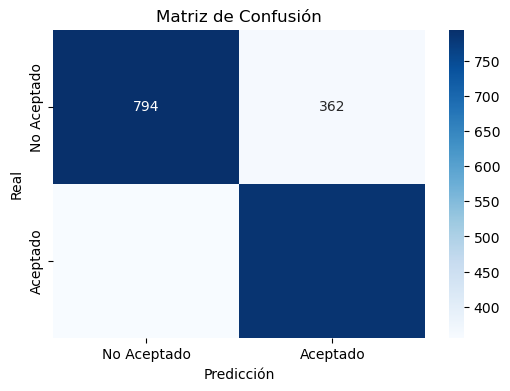

In [9]:
# Graficar matriz de confusión
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Aceptado", "Aceptado"], yticklabels=["No Aceptado", "Aceptado"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

In [10]:
# 7. Curva ROC y AUC
y_probs = model.predict_proba(X_test)[:,1]  # Probabilidades para clase positiva
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

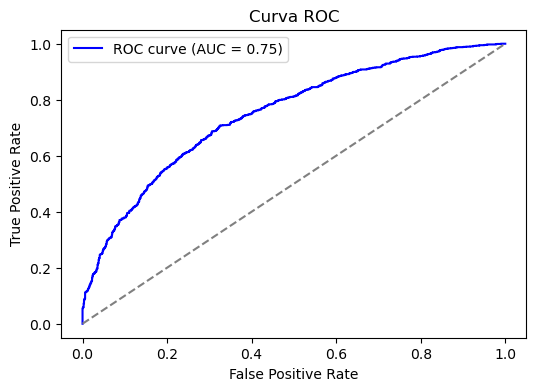

AUC Score: 0.7496


In [11]:
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.show()

print(f"AUC Score: {roc_auc:.4f}")

In [ ]:
# 8. Validación Cruzada con K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kfold_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')

print(f"K-Fold Accuracy Scores: {kfold_scores}")
print(f"Mean Accuracy: {kfold_scores.mean():.4f}")


In [12]:
import pandas as pd
import datetime

# Cargar el dataset de test
df_test = pd.read_csv("df_test_nolabel.csv")

# --- Preprocesamiento ---
# Debes replicar exactamente los pasos que aplicaste al entrenamiento.
# 1. Eliminar las columnas irrelevantes (como hiciste en entrenamiento)
cols_to_drop = ['id', 'LoanNr_ChkDgt', 'Name', 'ApprovalDate', 'DisbursementDate', 'State']
df_test_clean = df_test.drop(columns=cols_to_drop)

# 2. Aplicar one-hot encoding a las columnas categóricas que usaste en entrenamiento:
#    En tu entrenamiento usaste: ['Bank', 'City', 'BankState'] con drop_first=True.
df_test_clean = pd.get_dummies(df_test_clean, columns=['Bank', 'City', 'BankState', 'UrbanRural'], drop_first=True)

# 3. Imputar valores nulos (igual que en entrenamiento)
df_test_clean.fillna(0, inplace=True)

# --- Alinear las features ---
# Durante el entrenamiento, tu DataFrame final balanceado 'df_clean' tenía un cierto conjunto de columnas (features).
# Asumiendo que entrenaste el modelo con:
#   X_train = df_clean.drop('Accept', axis=1)
# Guarda la lista de features de entrenamiento:
features = list(df_balanced.drop('Accept', axis=1).columns)
print("Número de features en entrenamiento:", len(features))

# Reindexa el DataFrame de test para que tenga exactamente las mismas columnas, llenando con 0 las que no estén.
df_test_clean = df_test_clean.reindex(columns=features, fill_value=0)
print("Número de features en test:", df_test_clean.shape[1])

# --- Predicción ---
# Extrae el array de features del test
X_test = df_test_clean.values

# Realiza las predicciones usando tu modelo entrenado (en este caso, 'model')
df_test['Accept'] = model.predict(X_test)

# Asegúrate de que la columna 'Accept' sea de tipo entero
df_test['Accept'] = df_test['Accept'].astype(int)

# --- Exportar Submission ---
# Crea el archivo CSV con las columnas requeridas: 'id' y 'Accept'
filename = f"regresion_logistica_{datetime.datetime.now().strftime('%Y%m%d')}.csv"
df_test.to_csv(filename, columns=['id', 'Accept'], index=False)

print("Archivo de submission 'my-model.csv' generado correctamente.")

Número de features en entrenamiento: 14
Número de features en test: 14


/home/sofia.garcia.rincon/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


ValueError: X has 14 features, but LogisticRegression is expecting 1325 features as input.